# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.chdir("/content/drive/My Drive/PROJECT/")

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('/content/drive/My Drive/PROJECT/images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [5]:
print (data[10][1])
print(data.shape)

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]
(409, 2)


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [8]:
print (X_train.shape)

(409, 224, 224, 3)


In [9]:
print (masks.shape)

(409, 224, 224)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

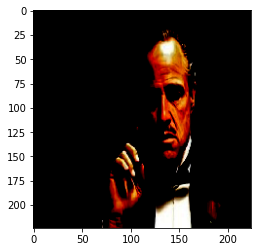

In [10]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

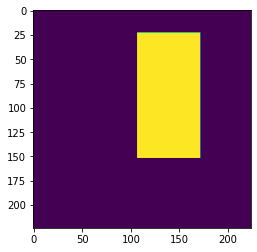

In [12]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False,alpha= 1.0,weights= "imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [18]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient


In [0]:
import tensorflow as tensorflow

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [24]:
model.fit(X_train,masks,epochs=1,batch_size=1,callbacks=[checkpoint,reduce_lr,stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 409 samples

Epoch 00001: loss improved from inf to 3.78845, saving model to model-3.79.h5
  1/409 [..............................] - ETA: 1:26:49 - loss: 3.7884 - dice_coefficient: 0.0891
Epoch 00001: loss improved from 3.78845 to 3.23969, saving model to model-3.24.h5
  2/409 [..............................] - ETA: 46:34 - loss: 3.5141 - dice_coefficient: 0.1002  
Epoch 00001: loss improved from 3.23969 to 2.19006, saving model to model-2.19.h5
  3/409 [..............................] - ETA: 34:43 - loss: 3.0727 - dice_coefficient: 0.1410
Epoch 00001: loss did not improve from 2.19006
  4/409 [..............................] - ETA: 27:14 - loss: 2.8788 - dice_coefficient: 0.1663
Epoch 00001: loss improved from 2.19006 to 1.50263, saving model to model-1.50.h5
  5/409 [..............................] - ETA: 23:02 - loss: 2.6036 - dice_coefficient: 0.1901
Epoch 00001: loss did not imp

### Get the predicted mask for a sample image   (3 marks)

In [0]:
prediction = model.predict(X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.49019611  0.4666667   0.6156863 ]
  [ 0.48235297  0.45882356  0.60784316]
  [ 0.41176474  0.39607847  0.5529412 ]
  ...
  [ 0.36470592  0.35686278  0.34117651]
  [ 0.26274514  0.25490201  0.23921573]
  [-0.2235294  -0.23137254 -0.24705881]]

 [[ 0.42745101  0.41960788  0.5529412 ]
  [ 0.4666667   0.45098042  0.60000002]
  [ 0.48235297  0.4666667   0.63137257]
  ...
  [ 0.48235297  0.47450984  0.45098042]
  [ 0.28627455  0.28627455  0.26274514]
  [-0.12941176 -0.13725489 -0.1607843 ]]

 [[ 0.4039216   0.41960788  0.54509807]
  [ 0.4666667   0.47450984  0.6156863 ]
  [ 0.47450984  0.48235297  0.63921571]
  ...
  [ 0.39607847  0.38039219  0.38823533]
  [ 0.35686278  0.34901965  0.34901965]
  [-0.06666666 -0.08235294 -0.0745098 ]]

 ...

 [[ 0.27843142  0.29411769  0.45882356]
  [ 0.28627455  0.30196083  0.47450984]
  [ 0.17647064  0.19215691  0.38823533]
  ...
  [ 0.34901965  0.38823533  0.62352943]
  [ 0.39607847  0.43529415  0.67058825]
  [ 0.36470592  0.4039216   0.63921571]]

 [

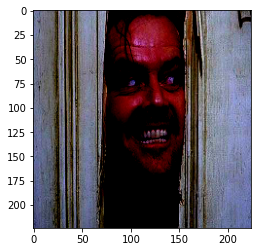

In [33]:
n = 150
sample_image = X_train[n]

print(X_train[n])
pyplot.imshow(X_train[n])

[[6.8545341e-07 6.8545341e-07 5.3644180e-07 ... 5.0067902e-06
  5.7816505e-06 5.7816505e-06]
 [6.8545341e-07 6.8545341e-07 5.3644180e-07 ... 5.0067902e-06
  5.7816505e-06 5.7816505e-06]
 [8.6426735e-07 8.6426735e-07 1.0728836e-06 ... 1.2755394e-05
  5.3346157e-06 5.3346157e-06]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


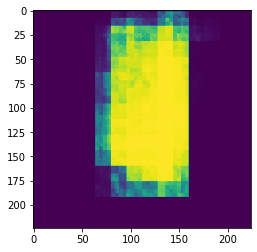

In [34]:
print(prediction[n])
pyplot.imshow(prediction[n])

### Impose the mask on the image (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


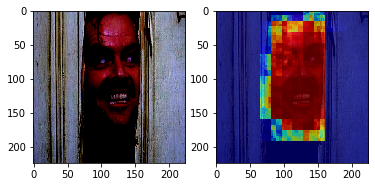

In [39]:
pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(X_train[n], 'gray', interpolation='none')
pyplot.subplot(1,2,2)
pyplot.imshow(X_train[n], 'gray', interpolation='none')
pyplot.imshow(prediction[n], 'jet', interpolation='none', alpha=0.7)
pyplot.show()